# Setup Imports

In [1]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from userdefinedmodels import *
import solarpanels

# Setup Locations and Weather

In [2]:
# setup locations
locations = {}

locations['Death Valley'] = (36.46301553642297, -116.87362879671764, 'Death Valley', -60, 'Etc/GMT+8')


In [3]:
# read files and setup weather
weathers = {}
for location in locations:
    names = '2022'
    filename = 'psm3_' + location + '_' + names + '.csv'
    weathers[location] = pd.read_csv(filename, index_col=0, parse_dates=True)


# Setup Systems

## Module Parameters

This study will use a Rich Solar 200W 12V Panel

In [4]:
rich_solar_12V_params = solarpanels.get_rich_solar_MEGA200_12V()

## Temperature Parameters

In [5]:
#temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['insulated_back_glass_polymer']

## Inverter (MPPT) Parameters  

In [6]:
# We'll start with no wire losses and perfect MPPT efficiency
#r_batt_wire = getWireResistance('8AWG', 5)
#r_pv_wire = getWireResistance('8AWG', 10)
r_batt_wire = 0
r_pv_wire = 0
mppt_eff = 1.0


mppt_parameters = {
    'v_batt': 14.6,
    'v_start_delta': 5.0,
    'v_continue_delta': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': mppt_eff
}

## System Configuration

In [7]:

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
arraySeries = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=1,
    modules_per_string=2,
    )

arrayParallel = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=2,
    modules_per_string=1,
    )



systemSeries = PVSystem(arrays=[arraySeries], 
                  inverter_parameters=mppt_parameters)

systemParallel = PVSystem(arrays=[arrayParallel],
                    inverter_parameters=mppt_parameters)


In [8]:


#mcSeries.run_model(weather)
#mcParallel.run_model(weather)


# Iterate over Locations

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: desoto
  ac_model: functools.partial(<function mppt at 0xffff2c334ae0>, ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: desoto
  ac_model: ...
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses)
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses
Death Valley Series Energy [W-hr]:  797114.04  Parallel Reduction [%]:  0.0
2022-07-11 00:00:00-08:00 102.49679586531232
Death Valley   2022-12-31  max cell temp [C]: 102.49679586531232


/tmp/ipykernel_87020/2838805431.py:144: RuntimeWarning: invalid value encountered in scalar divide
  if delta/series_energy > 0.0001 and enable_daily_delta:
/tmp/ipykernel_87020/2838805431.py:146: RuntimeWarning: invalid value encountered in scalar divide
  if delta/series_energy > 0.0001 and enable_plots:


102.49679586531232


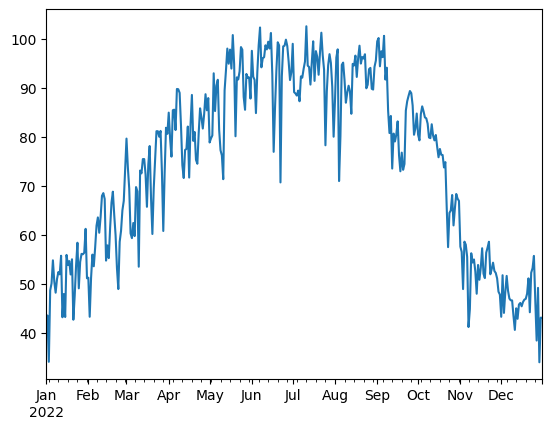

In [9]:
enable_plots = False
enable_daily_delta = False
# Iterate over locations
for location in locations:
    latitude, longitude, name, altitude, timezone = locations[location]

    # setup pvlib location
    pvlocation = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
        )
    
    # setup weather
    weather = weathers[location]

    # setup model chains
    mcSeries = ModelChain(systemSeries, 
                pvlocation, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="desoto",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )

    mcParallel = ModelChain(systemParallel, 
                pvlocation, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="desoto",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )

    # run model chains
    mcSeries.run_model(weather)
    mcParallel.run_model(weather)
    print(mcParallel)
    # calculate total energy produced
    year_series_energy = mcSeries.results.ac.sum() * 5/60
    year_parallel_energy = mcParallel.results.ac.sum() * 5/60
    # calculate reduction for parallel
    year_delta = year_series_energy - year_parallel_energy
    year_parallel_reduction = year_delta/year_series_energy * 100
    # print results
    print(location, 'Series Energy [W-hr]: ', round(year_series_energy, 2), ' Parallel Reduction [%]: ', round(year_parallel_reduction, 2))
    
    # Create a date range for January
    #dates = pd.date_range(start='2022-01-01', end='2022-01-31', tz=location.tz)
    # Create a date range for July
    dates = pd.date_range(start='2022-01-01', end='2022-12-31', tz=pvlocation.tz)

    # Interate over dates to find the date with the highest cell temperature
    max_cell_temp = 0
    max_cell_temp_date = None
    max_cell_temps = pd.Series()

    for date in dates:
        # Localize the date to the specified timezone
        date_index = pd.DatetimeIndex([date])
        # Get the sunrise and sunset times for the date
        sun_times = pvlocation.get_sun_rise_set_transit(date_index)
        # Extract the sunrise and sunset times and convert them to timestamps
        sunrise = sun_times['sunrise'].iloc[0]
        sunset = sun_times['sunset'].iloc[0]
        
        # Slice DataFrames to the range from sunrise to sunset
        parallel_cell_slice = mcParallel.results.cell_temperature.loc[sunrise:sunset]
        # Find the max cell temperature for parallel cases
        # within the slice period
        cell_temp = parallel_cell_slice.max()
        max_cell_temps.at[date] = cell_temp
        
        if cell_temp > max_cell_temp:
            max_cell_temp = cell_temp
            max_cell_temp_date = date
        
    print(max_cell_temp_date, max_cell_temp)
    max_cell_temps.plot()

    print(location, ' ', date.strftime('%Y-%m-%d'),' max cell temp [C]:' , max_cell_temp)
    
    # Iterate over the dates
    for date in dates:
        # Localize the date to the specified timezone
        
        # Create a DatetimeIndex from the localized_date
        date_index = pd.DatetimeIndex([date])
        
        # Get the sunrise and sunset times for the date
        sun_times = pvlocation.get_sun_rise_set_transit(date_index)
        
        # Extract the sunrise and sunset times and convert them to timestamps
        # sunrise = pd.Timestamp(sun_times['sunrise'].values[0], tz=location.tz)
        # sunset = pd.Timestamp(sun_times['sunset'].values[0], tz=location.tz)
        sunrise = sun_times['sunrise'].iloc[0]
        sunset = sun_times['sunset'].iloc[0]

        # add six hours to sunrise
        sunrise = sunrise + pd.Timedelta('6h')
        # subtract six hours from sunset
        sunset = sunset - pd.Timedelta('6h')
    
        
        # Slice DataFrames to the range from sunrise to sunset
        weather_slice = weather.loc[sunrise:sunset]
        series_dc_slice = mcSeries.results.dc.loc[sunrise:sunset]
        parallel_dc_slice = mcParallel.results.dc.loc[sunrise:sunset]
        series_ac_slice = mcSeries.results.ac.loc[sunrise:sunset]
        parallel_ac_slice = mcParallel.results.ac.loc[sunrise:sunset]
        parallel_cell_slice = mcParallel.results.cell_temperature.loc[sunrise:sunset]
        parallel_dc_ohmic_slice = mcParallel.results.dc_ohmic_losses.loc[sunrise:sunset]
        series_geff_slice = mcSeries.results.effective_irradiance.loc[sunrise:sunset]
        parallel_diode_slice = mcParallel.results.diode_params.loc[sunrise:sunset]
        parallel_weather_slice = mcParallel.results.weather.loc[sunrise:sunset]
        parallel_total_irrad_slice = mcParallel.results.total_irrad.loc[sunrise:sunset]
        parallel_effective_irradiance_slice = mcParallel.results.effective_irradiance.loc[sunrise:sunset]


        # Find the max cell temperature for parallel cases
        # within the slice period
        #max_cell_temp = parallel_cell_slice.max()

        # # Create a plot of the column of the sliced psm3_weatherFrames
        # fig, ax = plt.subplots()
        # weather_slice['ghi'].plot(ax=ax, label='ghi')
        # weather_slice['dni'].plot(ax=ax, label='dni')
        # weather_slice['dhi'].plot(ax=ax, label='dhi')
        # # Add a title to the plot
        # ax.set_title(date.strftime('%Y-%m-%d'))
        # # Add a legend to the plot
        # ax.legend()
        # # Show the plot
        # plt.show()

        # Calculate the total energy produced by the series and parallel systems
        series_energy = series_ac_slice.sum() * 5/60
        parallel_energy = parallel_ac_slice.sum() * 5/60
        delta = series_energy - parallel_energy

        if delta/series_energy > 0.0001 and enable_daily_delta:
            print (location, ' ', date.strftime('%Y-%m-%d'),' delta [W-hr]: ', delta, ' max cell temp [C]:' , max_cell_temp)
        if delta/series_energy > 0.0001 and enable_plots:
            #plot
            # Create a single figure with three subplots in a column
            fig, axs = plt.subplots(3, 1, figsize=(10, 15))
            
            # Create a plot of the MPPT Output
            series_ac_slice.plot(ax=axs[0], label='Series MPPT Output')
            parallel_ac_slice.plot(ax=axs[0], label='Parallel MPPT Output', linestyle=':')
            axs[0].set_title(location + ' ' + date.strftime('%Y-%m-%d') + ' MPPT Output')
            axs[0].text(0.05, 0.95, f'Series Energy: {series_energy:.2f}Wh', transform=axs[0].transAxes)
            axs[0].text(0.05, 0.90, f'Parallel Energy: {parallel_energy:.2f}Wh', transform=axs[0].transAxes)
            axs[0].text(0.05, 0.85, f'Delta: {delta:.2f}Wh', transform=axs[0].transAxes)
            axs[0].legend()

            # Create a new y-axis that shares the same x-axis
            ax2 = axs[0].twinx()

            # On the same subplot, but with a secondary y-axis, create a plot of the effective irradiance
            series_geff_slice.plot(ax=ax2, label='Geff', linestyle='--', color='r')

            # Set the labels for the y-axes
            axs[0].set_ylabel('Power [W]')
            ax2.set_ylabel('Effective Irradiance [W/m^2]')

            # Set the label for the x-axis
            axs[0].set_xlabel('Time')

            # Create a legend for the new y-axis
            ax2.legend(loc='upper right')

            # Ensure the legend for the original y-axis is still displayed
            axs[0].legend(loc='upper left')
            


            # Create a plot of the v_oc for the parallel case
            parallel_dc_slice['v_oc'].plot(ax=axs[1], label='V_oc')
            axs[1].axhline(y=mppt_parameters['v_batt'] + mppt_parameters['v_start_delta'], color='r', linestyle='--', label='V_start')
            axs[1].set_title(location + ' ' + date.strftime('%Y-%m-%d')+' Voc'+f' Max Cell Temp: {max_cell_temp:.2f}C')
            axs[1].legend()

            # Create a plot of the v_mp for the parallel case
            parallel_dc_slice['v_mp'].plot(ax=axs[2], label='V_mp')
            (parallel_dc_slice['v_mp']-parallel_dc_ohmic_slice['v_pv_wire_drop']).plot(ax=axs[2], label='V_mp-Ohmic', linestyle=':')
            axs[2].axhline(y=mppt_parameters['v_batt'] + mppt_parameters['v_continue_delta'], color='r', linestyle='--', label='V_continue')
            axs[2].set_title(location + ' ' + date.strftime('%Y-%m-%d')+' Vmp'+f' Max Cell Temp: {max_cell_temp:.2f}C')
            axs[2].legend()

            # Adjust the layout of the subplots
            plt.tight_layout()
            plt.show()

            # Additional plots
            parallel_cell_slice.plot()
            # print the first row of several parameters
            print('diode\n', parallel_diode_slice.iloc[0])
            print('dc\n',parallel_dc_slice.iloc[0])
            print('ac\n',parallel_ac_slice.iloc[0])
            print('cell temp\n',parallel_cell_slice.iloc[0])
            print('geff\n',series_geff_slice.iloc[0])
            print('weather\n',parallel_weather_slice.iloc[0])
            print('panel\n')
            print('total irrad\n',parallel_total_irrad_slice.iloc[0])
            print('effective irradiance\n',parallel_effective_irradiance_slice.iloc[0])
            for key, value in mcParallel.system.arrays[0].module_parameters.items():
                print(key, value)

print(max_cell_temp)


# Evaluate Day with Hottest Cell Temps
## Look at ohmic effects

                           p_pv_wire_loss  v_pv_wire_drop  p_batt_wire_loss  \
2022-09-06 05:25:00-08:00        0.000000        0.000000          0.000000   
2022-09-06 05:30:00-08:00        0.000000        0.000000          0.000000   
2022-09-06 05:35:00-08:00        0.003613        0.013522          0.004160   
2022-09-06 05:40:00-08:00        0.007757        0.019812          0.009114   
2022-09-06 05:45:00-08:00        0.014615        0.027194          0.017428   
...                                   ...             ...               ...   
2022-09-06 17:45:00-08:00        0.015206        0.027738          0.017618   
2022-09-06 17:50:00-08:00        0.008870        0.021185          0.010143   
2022-09-06 17:55:00-08:00        0.004291        0.014736          0.004812   
2022-09-06 18:00:00-08:00        0.001608        0.009019          0.001751   
2022-09-06 18:05:00-08:00        0.000000        0.000000          0.000000   

                           v_batt_wire_drop  
2022-

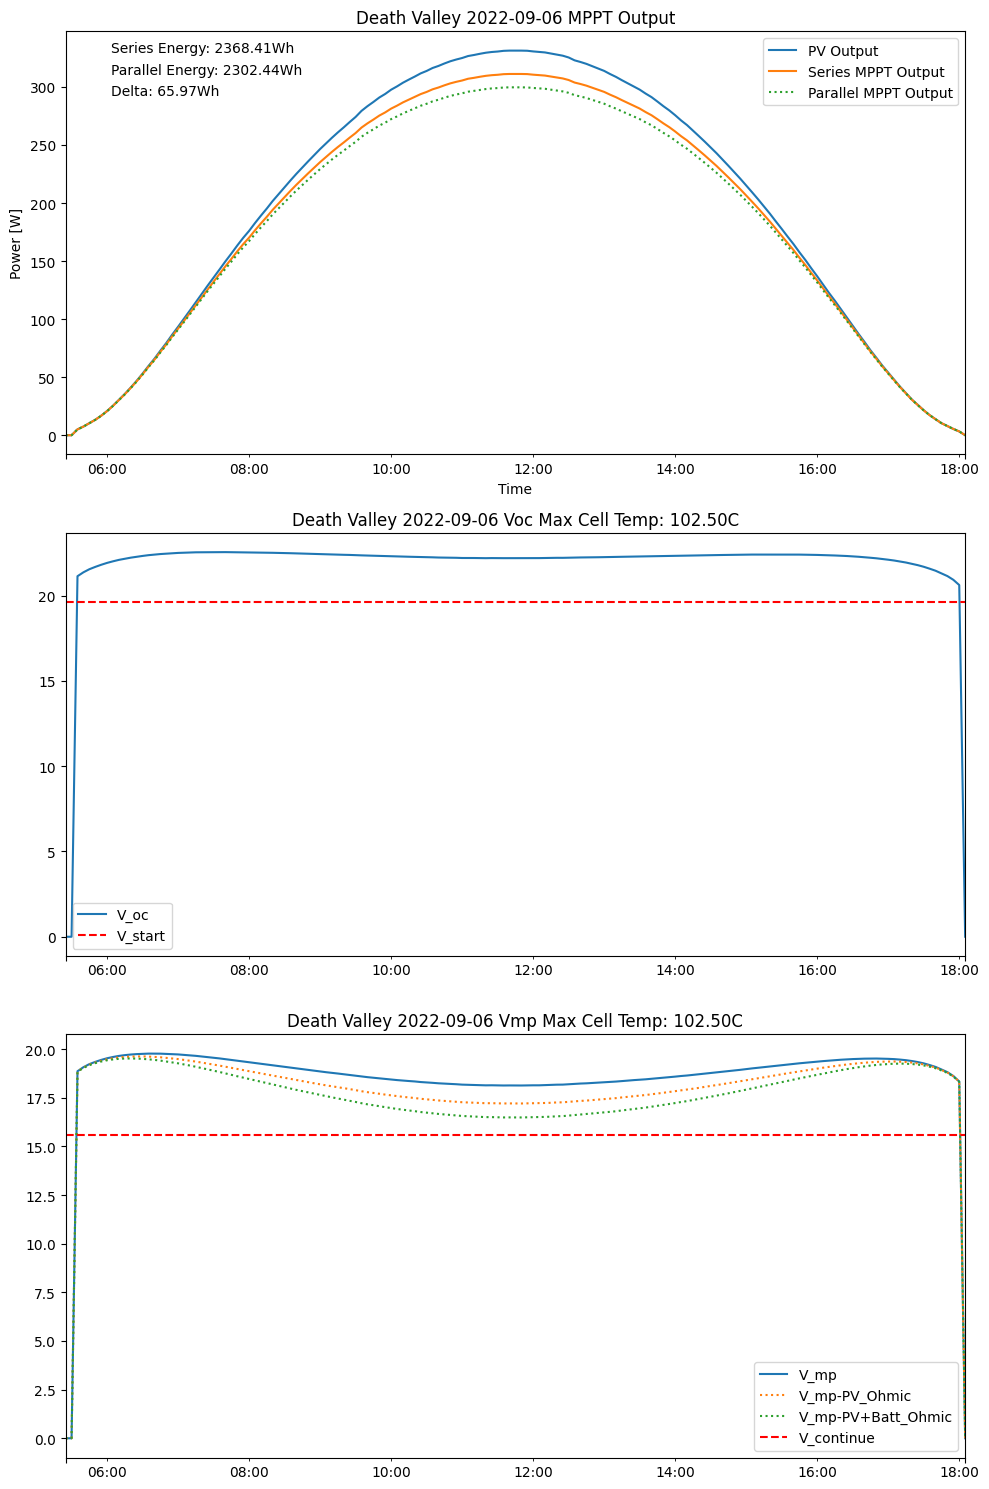

102.49679586531232


In [10]:
#setup weather
dates = pd.date_range(start='2022-09-06', end='2022-09-06', tz=pvlocation.tz)
date = pd.Timestamp('2022-09-06', tz=pvlocation.tz)
date_index = pd.DatetimeIndex([date])
# Get the sunrise and sunset times for the date
sun_times = pvlocation.get_sun_rise_set_transit(date_index)
# Extract the sunrise and sunset times and convert them to timestamps
sunrise = sun_times['sunrise'].iloc[0]
sunset = sun_times['sunset'].iloc[0]
# slice weather to the range from sunrise to sunset
weather_hot_cell = weather.loc[sunrise:sunset]

#setup system and model chains
r_batt_wire = getWireResistance('12AWG', 20) #400W at 14V ≈ 29A -> 10AWG
r_pv_wire = getWireResistance('14AWG', 20) #400W at 20.4(Vmp) ≈ 19A -> 14AWG
#r_batt_wire = 10*r_batt_wire
#r_pv_wire = 0
mppt_eff = 1.0

mppt_parameters = {
    'v_batt': 14.6,
    'v_start_delta': 5.0,
    'v_continue_delta': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': mppt_eff
}

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
arraySeries = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=1,
    modules_per_string=2,
    )

arrayParallel = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=2,
    modules_per_string=1,
    )

systemSeries = PVSystem(arrays=[arraySeries], 
                  inverter_parameters=mppt_parameters)

systemParallel = PVSystem(arrays=[arrayParallel],
                    inverter_parameters=mppt_parameters)
mcSeries = ModelChain(systemSeries, 
            pvlocation, 
            aoi_model="physical", 
            spectral_model="no_loss", 
            dc_model="desoto",
            ac_model=mppt,
            dc_ohmic_model=pv_wire_loss
            )
mcParallel = ModelChain(systemParallel, 
            pvlocation, 
            aoi_model="physical", 
            spectral_model="no_loss", 
            dc_model="desoto",
            ac_model=mppt,
            dc_ohmic_model=pv_wire_loss
            )

# run model chains
mcSeries.run_model(weather_hot_cell)
mcParallel.run_model(weather_hot_cell)

series_energy = mcSeries.results.ac.sum() * 5/60
parallel_energy = mcParallel.results.ac.sum() * 5/60
delta = series_energy - parallel_energy

# plot
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Create a plot of the MPPT Output
mcSeries.results.dc['p_mp'].plot(ax=axs[0], label='PV Output')
mcSeries.results.ac.plot(ax=axs[0], label='Series MPPT Output')
mcParallel.results.ac.plot(ax=axs[0], label='Parallel MPPT Output', linestyle=':')
axs[0].set_title(location + ' ' + date.strftime('%Y-%m-%d') + ' MPPT Output')
axs[0].text(0.05, 0.95, f'Series Energy: {series_energy:.2f}Wh', transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f'Parallel Energy: {parallel_energy:.2f}Wh', transform=axs[0].transAxes)
axs[0].text(0.05, 0.85, f'Delta: {delta:.2f}Wh', transform=axs[0].transAxes)
axs[0].legend()

# Set the labels for the y-axes
axs[0].set_ylabel('Power [W]')

# Set the label for the x-axis
axs[0].set_xlabel('Time')

# Create a legend for the new y-axis

# Ensure the legend for the original y-axis is still displayed
axs[0].legend(loc='upper right')



# Create a plot of the v_oc for the parallel case
mcParallel.results.dc['v_oc'].plot(ax=axs[1], label='V_oc')
axs[1].axhline(y=mppt_parameters['v_batt'] + mppt_parameters['v_start_delta'], color='r', linestyle='--', label='V_start')
axs[1].set_title(location + ' ' + date.strftime('%Y-%m-%d')+' Voc'+f' Max Cell Temp: {max_cell_temp:.2f}C')
axs[1].legend()

# Create a plot of the v_mp for the parallel case
#debug
print(mcParallel.results.dc_ohmic_losses)

mcParallel.results.dc['v_mp'].plot(ax=axs[2], label='V_mp')
(mcParallel.results.dc['v_mp']-mcParallel.results.dc_ohmic_losses['v_pv_wire_drop']).plot(ax=axs[2], label='V_mp-PV_Ohmic', linestyle=':')
(mcParallel.results.dc['v_mp']-mcParallel.results.dc_ohmic_losses['v_pv_wire_drop']-mcParallel.results.dc_ohmic_losses['v_batt_wire_drop']).plot(ax=axs[2], label='V_mp-PV+Batt_Ohmic', linestyle=':')

axs[2].axhline(y=mppt_parameters['v_batt'] + mppt_parameters['v_continue_delta'], color='r', linestyle='--', label='V_continue')
axs[2].set_title(location + ' ' + date.strftime('%Y-%m-%d')+' Vmp'+f' Max Cell Temp: {max_cell_temp:.2f}C')
axs[2].legend()

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()
print(max_cell_temp)
